# EDA_Project_3_Обучение модели для сайта Booking

Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель. Готовы приступить?

Условия соревнования:

* Делаем реальный ML продукт, который потом сможет нормально работать на новых данных.


Метрика качества Результаты оцениваются по метрике MAPE 
Файл представления: Для каждого **id** отеля в наборе тестовых данных вы должны предсказать рейтинг отеля для **reviewer_score** переменной. Файл должен содержать заголовок и иметь следующий формат: ``` reviewer_score,id 1,1 ```

In [1]:
# ЗАГРУЗКА НЕОБХОДИМЫХ БИБЛИОТЕК

# для работы с данными
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# для работы с признаками
# кодирования признаков
import category_encoders as ce
# нормализации признаков
from sklearn import preprocessing

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import plotly.express as px

 # Загружаем специальный удобный инструмент для расчетов
from scipy import stats


 # Загружаем специальный удобный инструмент для проверки гипотезы
from scipy.stats import f_oneway


# Загружаем специальный удобный инструмент для оценки значимости
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

# импортируем библиотеки для оценки тональности текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

# загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# библиотеки для работы с моделью
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели


   


* hotel_address — адрес отеля;

* review_date — дата, когда рецензент разместил соответствующий отзыв;

* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

* hotel_name — название отеля;

* reviewer_nationality — страна рецензента;

* negative_review — отрицательный отзыв, который рецензент дал отелю;

* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

* positive_review — положительный отзыв, который рецензент дал отелю;

* review_total_positive_word_counts — общее количество слов в положительном отзыве.

* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;

* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

* total_number_of_reviews — общее количество действительных отзывов об отеле;

* tags — теги, которые рецензент дал отелю;

* days_since_review — количество дней между датой проверки и датой очистки;

* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

* lat — географическая широта отеля;

* lng — географическая долгота отеля.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
hotels = pd.read_csv('data/hotels.csv')
hotels.head(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [4]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [5]:
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,384355.000000,384355.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.443522,2.823402
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.466936,4.579043
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214662,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


In [6]:
hotels.isnull().sum ()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           2448
lng                                           2448
dtype: int64

array([[<AxesSubplot: title={'center': 'additional_number_of_scoring'}>,
        <AxesSubplot: title={'center': 'average_score'}>,
        <AxesSubplot: title={'center': 'review_total_negative_word_counts'}>],
       [<AxesSubplot: title={'center': 'total_number_of_reviews'}>,
        <AxesSubplot: title={'center': 'review_total_positive_word_counts'}>,
        <AxesSubplot: title={'center': 'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot: title={'center': 'reviewer_score'}>,
        <AxesSubplot: title={'center': 'lat'}>,
        <AxesSubplot: title={'center': 'lng'}>]], dtype=object)

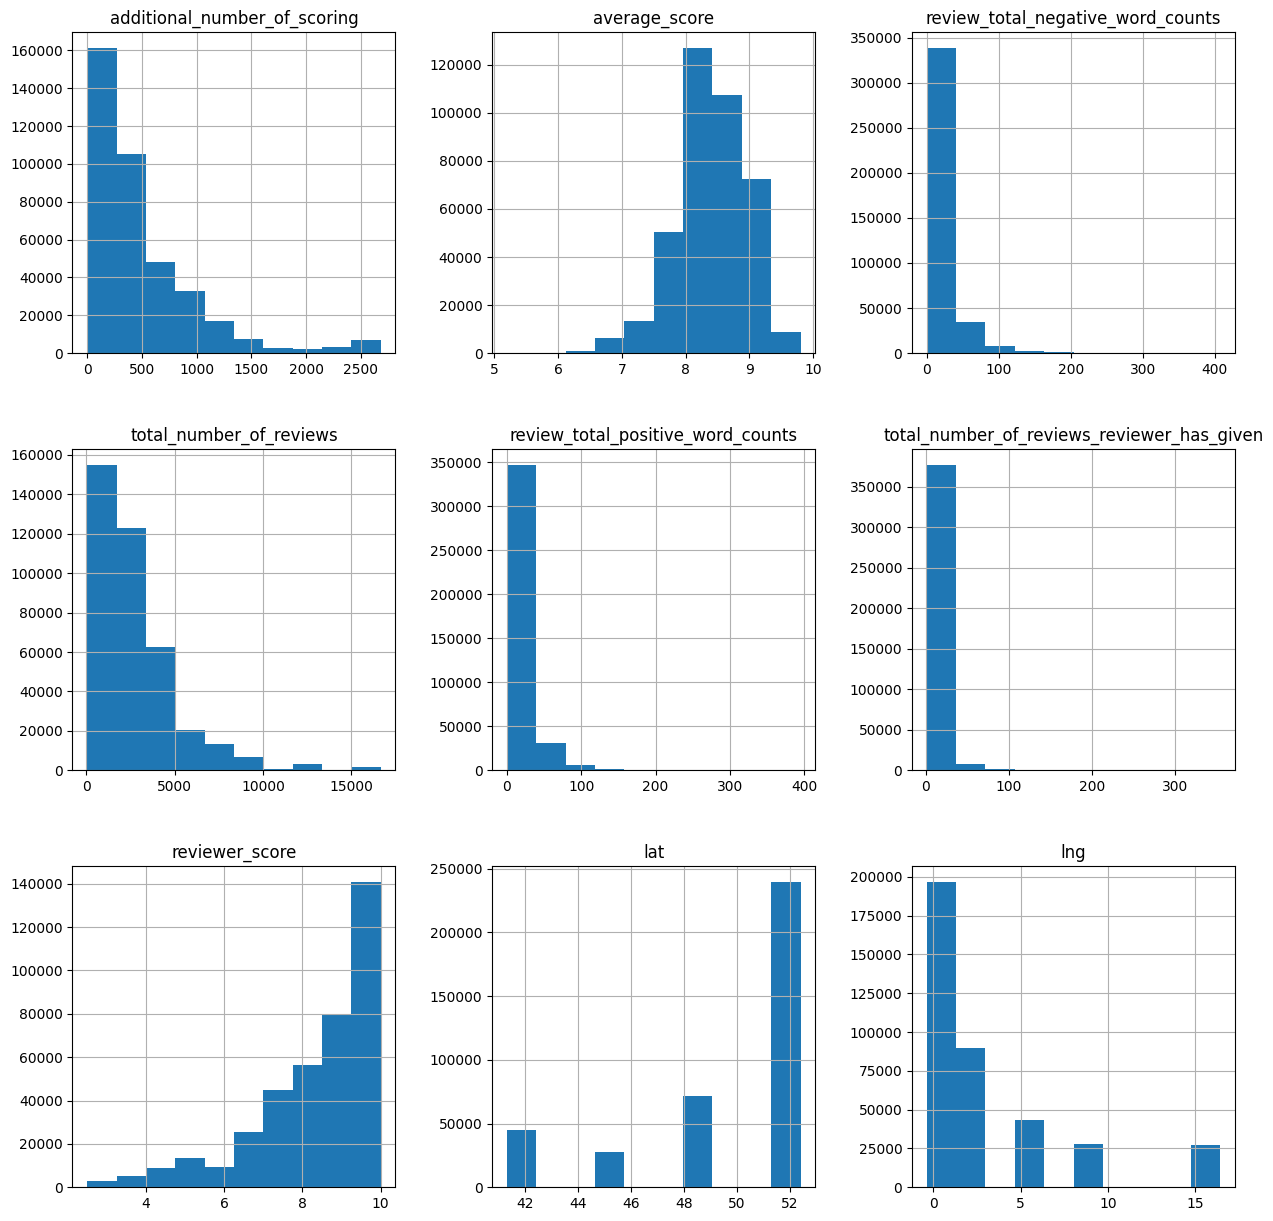

In [7]:
hotels.hist(figsize=(15,15))

<!-- 1. Создание и преобразование признаков

* Страна отеля (будет категориальным)
* Год из даты отзыва (будет категориальным)
* Признак reviewer_nationality преобразуем в категориальный
* 
* Количество проведённых ночей по тегах
* Количество тегов
* Наличие соответствующего тега (выберем наиболее популярные, остальные - заменим значением)
* Дополнительные признаки, которые можно вытащить из тегов (возможно их можно как-то разделить на группы)
* Сумма длины позитивного и негативного отзыва
* Разница между длиной позитивного и негативного отзыва
* Соотношение длины позитивного и негативного отзыва
* Признаки по эмоциональной окраске текста (библиотека nltk) -->

##  Создание и преобразование признаков

***Предлагаю создать следующие признаки:***

* Страна отеля преобразуем в категориальный
* Год и Месяц из даты отзыва
* Признак Имени отеля преобразуем в категориальный
* Признак путешествие внутри своей страны
* Признак reviewer_nationality преобразуем в категориальный
* Признаки эмоциональной окраске текста (библиотека nltk)
* Количество тегов
* Количество проведённых ночей по тегах
* Дополнительные признаки которые можно вытащить из тегов, выберем наиболее популярные.


### Признак страна отеля 

In [8]:
# Рассмотрим признака (hotel_address) адреса отеля.
# Составим список адресов отелей.

hotel_address_list = hotels.hotel_address.tolist()

print(f'Датафрейм содержит {hotels.hotel_address.nunique()} уникальных адреса')
display(hotel_address_list[:20])

Датафрейм содержит 1493 уникальных адреса


['Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom',
 '130 134 Southampton Row Camden London WC1B 5AF United Kingdom',
 '151 bis Rue de Rennes 6th arr 75006 Paris France',
 '216 Avenue Jean Jaures 19th arr 75019 Paris France',
 'Molenwerf 1 1014 AG Amsterdam Netherlands',
 'Via Mecenate 121 20138 Milan Italy',
 '97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom',
 'Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria',
 '190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom',
 'Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom',
 'Molenwerf 1 1014 AG Amsterdam Netherlands',
 '34 44 Barkston Gardens Kensington and Chelsea London SW5 0EW United Kingdom',
 '16 Sumner Place Kensington and Chelsea London SW7 3EG United Kingdom',
 '97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom',
 'Putget 68 Sarri St Gervasi 08023 Barcelona Spain',
 'Caspe 103 Eixample 08013 Barcelona Spain',
 '1 Kings Cro

In [9]:
# С помощью функции извлечем название страны и города в отдельные признаки.

def city_and_country(address):
    words_list = address.split(' ')
    if 'United Kingdom' in address:
        return('United Kingdom', words_list[-5])
    else:
        return(words_list[-1], words_list[-2])

hotels[['hotel_country', 'hotel_city']] = hotels['hotel_address'].apply(city_and_country).apply(pd.Series)

In [10]:
hotels.hotel_country.value_counts()

United Kingdom    196774
Spain              45132
France             44830
Netherlands        43006
Austria            29178
Italy              27883
Name: hotel_country, dtype: int64

In [11]:
hotels.hotel_city.value_counts()

London       196774
Barcelona     45132
Paris         44830
Amsterdam     43006
Vienna        29178
Milan         27883
Name: hotel_city, dtype: int64

In [12]:
# Закодируем признак странны отеля hotel_country.

encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True) 
type_bin = encoder.fit_transform(hotels['hotel_country']) 
hotels = pd.concat([hotels, type_bin], axis=1)

### Заполним имеющиеся пропуски 

In [13]:
# Заполним пропуски в признаках (lat, lng) используя признак город отеля.

hotels[hotels['hotel_city'] == 'Amsterdam'] =  hotels[hotels['hotel_city'] == 'Amsterdam'].fillna({'lat':52.362209,'lng':4.885346})
hotels[hotels['hotel_city'] == 'Barcelona'] =  hotels[hotels['hotel_city'] == 'Barcelona'].fillna({'lat':41.389125,'lng':2.169152})
hotels[hotels['hotel_city'] == 'London'] =  hotels[hotels['hotel_city'] == 'London'].fillna({'lat':51.510737,'lng':-0.139075})
hotels[hotels['hotel_city'] == 'Milan'] =  hotels[hotels['hotel_city'] == 'Milan'].fillna({'lat':45.479619,'lng':9.191844})
hotels[hotels['hotel_city'] == 'Paris'] =  hotels[hotels['hotel_city'] == 'Paris'].fillna({'lat':48.863658,'lng':2.326816})
hotels[hotels['hotel_city'] == 'Vienna'] =  hotels[hotels['hotel_city'] == 'Vienna'].fillna({'lat':48.203368,'lng':16.367176})

In [14]:
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
hotel_country                                 0
hotel_city                                    0
hotel_country_United Kingdom                  0
hotel_country_France                    

In [15]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [16]:
# Удалим признаки адреса и города.

hotels.drop(['hotel_city', 'hotel_address'], axis=1 , inplace=True)

### Признак Года и Месяца 

In [17]:
# Анализ признака даты отзыва.
# Конвертируем формат столбца review_date в формат даты и времени

hotels['review_date'] = pd.to_datetime(hotels['review_date'], dayfirst = False, yearfirst = False)

# Разберем более детально признак даты

hotels['review_date'].describe()

C:\Users\Usser\AppData\Local\Temp\ipykernel_2840\4273973833.py:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  hotels['review_date'].describe()


count                  386803
unique                    731
top       2017-08-02 00:00:00
freq                     1911
first     2015-08-04 00:00:00
last      2017-08-03 00:00:00
Name: review_date, dtype: object

In [18]:
#  Выделяем признаки года и месяца зная дату отзыва.

hotels['rewiew_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month

# Удалим признак даты отзыва.

hotels.drop(['review_date'], axis=1 , inplace=True)

In [19]:
hotels.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,lng,hotel_country,hotel_country_United Kingdom,hotel_country_France,hotel_country_Netherlands,hotel_country_Italy,hotel_country_Austria,hotel_country_Spain,rewiew_year,review_month
0,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,-0.143671,United Kingdom,1,0,0,0,0,0,2016,2
1,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,...,-0.123097,United Kingdom,1,0,0,0,0,0,2017,1
2,32,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,...,2.325643,France,0,1,0,0,0,0,2016,10


### Признак имени отеля

In [20]:
# Рассмотрим признак hotel_name.

hotel_name_list = hotels.hotel_name.tolist()

print(f'Датафрейм содержит {hotels.hotel_name.nunique()} уникальных имен отелей')
display(hotel_name_list[:30])

Датафрейм содержит 1492 уникальных имен отелей


['The May Fair Hotel',
 'Mercure London Bloomsbury Hotel',
 'Legend Saint Germain by Elegancia',
 'Mercure Paris 19 Philharmonie La Villette',
 'Golden Tulip Amsterdam West',
 'Novotel Milano Linate Aeroporto',
 'Holiday Inn London Kensington Forum',
 'Mercure Josefshof Wien',
 'The Gore Hotel Starhotels Collezione',
 'Hilton London Kensington Hotel',
 'Golden Tulip Amsterdam West',
 'Hotel Indigo London Kensington',
 'Number Sixteen',
 'Holiday Inn London Kensington Forum',
 'Catalonia Park Putxet',
 'Ayre Hotel Caspe',
 'Crowne Plaza London Kings Cross',
 'Holiday Inn London Kensington',
 'New Linden Hotel',
 'Silken Ramblas',
 'Mondrian London',
 'Clayton Crown Hotel London',
 'Holiday Inn London Stratford City',
 'Park Plaza County Hall London',
 'H tel Arvor Saint Georges',
 'The Ring Vienna s Casual Luxury Hotel',
 'Olivia Balmes Hotel',
 'Best Western Premier Hotel Couture',
 'Hilton Amsterdam',
 '88 Studios']

In [21]:
# Закодируем признак (hotel_name). 
# Удалим исходный признак.

bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования 
type_bin = bin_encoder.fit_transform(hotels['hotel_name']) 
hotels = pd.concat([hotels, type_bin], axis=1)

hotels.drop(['hotel_name'], axis=1, inplace=True)
display(hotels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   reviewer_nationality                        386803 non-null  object 
 3   negative_review                             386803 non-null  object 
 4   review_total_negative_word_counts           386803 non-null  int64  
 5   total_number_of_reviews                     386803 non-null  int64  
 6   positive_review                             386803 non-null  object 
 7   review_total_positive_word_counts           386803 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 9   reviewer_score                              386803 non-null  float64
 

None

### Признак путешествие внутри своей страны

In [22]:
# Анализ признака страны рецензента(reviewer_nationality ).
# Смотрим количество стран из которых были люди оставившие отзыв

nationality = hotels['reviewer_nationality'].nunique()
print(f'Количество стран из которых были люди оставившие отзыв: {nationality}.')

Количество стран из которых были люди оставившие отзыв: 225.


In [23]:
# Создаем функцию, которая убирает пробелы в конце и в начале
def function_city(nation):
    nation = nation.strip()
    return nation 

# Применяем функцию удаляющую пробелы в конце и в начале
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(function_city)

In [24]:
# Создадим признак (travel_to_country) посмотрим есть ли люди путешествующие внутри своей страны.

hotels['travel_to_country'] = hotels.apply(lambda x: 1 if x['reviewer_nationality'] == x['hotel_country']
                                           else 0, axis=1)
hotels['travel_to_country'].value_counts()


0    252862
1    133941
Name: travel_to_country, dtype: int64

In [25]:
# Удалим признак страны отеля.
hotels.drop(['hotel_country'], axis=1, inplace=True)

In [26]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   reviewer_nationality                        386803 non-null  object 
 3   negative_review                             386803 non-null  object 
 4   review_total_negative_word_counts           386803 non-null  int64  
 5   total_number_of_reviews                     386803 non-null  int64  
 6   positive_review                             386803 non-null  object 
 7   review_total_positive_word_counts           386803 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 9   reviewer_score                              386803 non-null  float64
 

### Признак страны рецензента

In [27]:
# Произведем кодировку признака (reviewer_nationality). 
# Удалим исходный признак.

bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

hotels.drop(['reviewer_nationality'], axis=1, inplace=True)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   negative_review                             386803 non-null  object 
 3   review_total_negative_word_counts           386803 non-null  int64  
 4   total_number_of_reviews                     386803 non-null  int64  
 5   positive_review                             386803 non-null  object 
 6   review_total_positive_word_counts           386803 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 8   reviewer_score                              386803 non-null  float64
 9   tags                                        386803 non-null  object 
 

In [28]:
hotels.head()

,additional_number_of_scoring,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,...,hotel_name_10,travel_to_country,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,581,8.4,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",...,1,1,0,0,0,0,0,0,0,1
1,299,8.3,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",...,0,1,0,0,0,0,0,0,0,1
2,32,8.9,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",...,1,0,0,0,0,0,0,0,1,0
3,34,7.5,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",...,0,0,0,0,0,0,0,0,0,1
4,914,8.5,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",...,1,0,0,0,0,0,0,0,1,1


### Признак эмоциональной окраски текста

In [29]:
# Произведем эмоциональной окраски текста, проанализируем позитивные и негативные отзывы с помощью SentimentIntensityAnalyzer. 
# Результаты занесем в отдельные признаки. 

sent_analyzer = SentimentIntensityAnalyzer()

hotels['positive_review_dict'] = hotels['positive_review'].apply(sent_analyzer.polarity_scores)
hotels['negative_review_dict'] = hotels['negative_review'].apply(sent_analyzer.polarity_scores)

# создадим новые признаки из негативнного отзыва
hotels['negative_neg'] = hotels['negative_review_dict'].apply(lambda x: x['neg'])
hotels['negative_neu'] = hotels['negative_review_dict'].apply(lambda x: x['neu'])
hotels['negative_pos'] = hotels['negative_review_dict'].apply(lambda x: x['pos'])
hotels['negative_compound'] = hotels['negative_review_dict'].apply(lambda x: x['compound'])

# создадим новые признаки из позитивного отзыва
hotels['positive_neg'] = hotels['positive_review_dict'].apply(lambda x: x['neg'])
hotels['positive_neu'] = hotels['positive_review_dict'].apply(lambda x: x['neu'])
hotels['positive_pos'] = hotels['positive_review_dict'].apply(lambda x: x['pos'])
hotels['positive_compound'] = hotels['positive_review_dict'].apply(lambda x: x['compound'])

# Исходные признаки удалим.

hotels.drop(['positive_review', 'negative_review', 'positive_review_dict', 'negative_review_dict'], axis=1, inplace=True)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 47 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   tags                                        386803 non-null  object 
 8   days_since_review                           386803 non-null  object 
 9   lat                                         386803 non-null  float64
 

### Признак количество дней между датой проверки и датой очистки 

In [30]:
# Переведём столбец days_since_review в числовой формат

hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: x.split(" ")[0]).astype('int')

In [31]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 47 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   tags                                        386803 non-null  object 
 8   days_since_review                           386803 non-null  int32  
 9   lat                                         386803 non-null  float64
 

### Признак количество тегов

In [32]:
# Проанализируем признак (tags) теги, которые рецензент дал отелю.

popular_tags = list(hotels['tags'].value_counts().nlargest(30).index)
display(popular_tags)

["[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",
 "[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",
 "[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",
 "[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",
 "[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",
 "[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",
 "[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ']",
 "[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",
 "[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",
 "[' Leisure trip ', ' Couple ', ' Deluxe Dou

In [33]:
# Создадим признак количества тегов.

hotels['count_tags'] = hotels['tags'].apply(lambda x: len(x.split(',')))

hotels['count_tags'].value_counts()

5    223455
4    158589
3      4126
6       563
2        65
1         5
Name: count_tags, dtype: int64

In [34]:
hotels.isnull().sum()

additional_number_of_scoring                  0
average_score                                 0
review_total_negative_word_counts             0
total_number_of_reviews                       0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
hotel_country_United Kingdom                  0
hotel_country_France                          0
hotel_country_Netherlands                     0
hotel_country_Italy                           0
hotel_country_Austria                         0
hotel_country_Spain                           0
rewiew_year                                   0
review_month                                  0
hotel_name_0                                  0
hotel_name_1                            

### Признаки количество проведённых ночей из тегов и признаки из наиболее популярных тегов.

In [35]:
# Создадим признак количествот ночей, если количество не указано, то поставим 0 ночей

hotels['stayed_nights'] = hotels['tags'].str.extract(r'Stayed (\d+) night').fillna(0).astype(int)
stayed_nights = hotels['stayed_nights'].value_counts() # проверяем результат
print(stayed_nights[:32])

# Создадим признак "Развлекательгая поездка"
hotels['Leisure_trip'] = hotels['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0) 
Leisure_trip = hotels['Leisure_trip'].value_counts() # проверяем результат
print(Leisure_trip)

# Создадим признак "бизнес путешествие"
hotels['Business_trip'] = hotels['tags'].apply(lambda x: 1 if 'Business trip' in x else 0) 
Business_trip = hotels['Business_trip'].value_counts() # проверяем результат
print(Business_trip)

# Создадим признак "путешествие в паре"
hotels['traveling_couple'] = hotels['tags'].apply(lambda x: 1 if 'Couple' in x else 0) 
traveling_couple = hotels['traveling_couple'].value_counts() # проверяем результат
print(traveling_couple)

# Создадим признак "путешествует один"
hotels['traveling_solo'] = hotels['tags'].apply(lambda x: 1 if 'Solo' in x else 0) 
traveling_solo = hotels['traveling_solo'].value_counts() # проверяем результат
print(traveling_solo)

# Создадим признак "Отправлено с мобильного устройства"
hotels['Submitted_mobile_device'] = hotels['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0) 
Submitted_mobile_device = hotels['Submitted_mobile_device'].value_counts() # проверяем результат
print(Submitted_mobile_device)

# Создадим признак "Семья с маленькими детьми"
hotels['Family_with_young_children'] = hotels['tags'].apply(lambda x: 1 if 'Family with young children' in x else 0) 
Family_with_young_children = hotels['Family_with_young_children'].value_counts() # проверяем результат
print(Family_with_young_children)

# Создадим признак "Семья с детьми старшего возраста"
hotels['Family_with_older_children'] = hotels['tags'].apply(lambda x: 1 if 'Family with older children' in x else 0) 
Family_with_older_children = hotels['Family_with_older_children'].value_counts() # проверяем результат
print(Family_with_older_children)

# Удалим исходный признак.

hotels.drop(['tags'], axis=1, inplace=True)

C:\Users\Usser\AppData\Local\Temp\ipykernel_2840\2051610583.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(stayed_nights[:32])


1     145373
2     100263
3      72000
4      35748
5      15611
6       7399
7       5549
8       1910
9        966
10       663
11       306
12       217
14       184
13       174
0        146
15        87
16        38
17        27
18        24
19        23
21        19
20        17
27        10
30        10
22         8
28         7
26         6
23         6
24         5
25         4
29         3
Name: stayed_nights, dtype: int64
1    313593
0     73210
Name: Leisure_trip, dtype: int64
0    324814
1     61989
Name: Business_trip, dtype: int64
0    197591
1    189212
Name: traveling_couple, dtype: int64
0    305568
1     81235
Name: traveling_solo, dtype: int64
1    230778
0    156025
Name: Submitted_mobile_device, dtype: int64
0    340967
1     45836
Name: Family_with_young_children, dtype: int64
0    367001
1     19802
Name: Family_with_older_children, dtype: int64


## Проверка на нормальность, нормализация и стандартизация

In [36]:
#для тестов
from scipy.stats import shapiro


list_of_columns = [
   'additional_number_of_scoring',
    'average_score',
    'total_number_of_reviews', 
    'total_number_of_reviews_reviewer_has_given'
]


for i in list_of_columns:

	_, p = shapiro(hotels[i])
	print('p=%.3f' % p)

	# Интерпретация 

	if p > 0.05:
		print(f'{i}: Данные распределены нормально')
	else:
		print(f'{i}: Данные распределены ненормально')
  

p=0.000
additional_number_of_scoring: Данные распределены ненормально
p=0.000
average_score: Данные распределены ненормально
p=0.000
total_number_of_reviews: Данные распределены ненормально
p=0.000
total_number_of_reviews_reviewer_has_given: Данные распределены ненормально


c:\Users\Usser\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [37]:
hotels[list_of_columns].describe() 


,additional_number_of_scoring,average_score,total_number_of_reviews,total_number_of_reviews_reviewer_has_given
count,386803.000000,386803.000000,386803.000000,386803.00000
mean,498.246536,8.397231,2743.992042,7.17725
std,500.258012,0.547881,2316.457018,11.05442
min,1.000000,5.200000,43.000000,1.00000
25%,169.000000,8.100000,1161.000000,1.00000
50%,342.000000,8.400000,2134.000000,3.00000
75%,660.000000,8.800000,3613.000000,8.00000
max,2682.000000,9.800000,16670.000000,355.00000


In [38]:
# Проводим нормализацию RobustScaler, так как в датасете есть выбросы

r_scaler = preprocessing.RobustScaler()
hotels[list_of_columns] = r_scaler.fit_transform(hotels[list_of_columns]) 

hotels[list_of_columns].describe() # смотрим на распределение данных


,additional_number_of_scoring,average_score,total_number_of_reviews,total_number_of_reviews_reviewer_has_given
count,386803.000000,386803.000000,386803.000000,386803.000000
mean,0.318221,-0.003956,0.248773,0.596750
std,1.018855,0.782687,0.944721,1.579203
min,-0.694501,-4.571429,-0.852773,-0.285714
25%,-0.352342,-0.428571,-0.396819,-0.285714
50%,0.000000,0.000000,0.000000,0.000000
75%,0.647658,0.571429,0.603181,0.714286
max,4.765784,2.000000,5.928222,50.285714


In [39]:
# s_scaler = preprocessing.StandardScaler()
# hotels[list_of_columns] = s_scaler.fit_transform(hotels[list_of_columns]) 
# hotels[list_of_columns].describe()

In [40]:
hotels.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,...,positive_compound,count_tags,stayed_nights,Leisure_trip,Business_trip,traveling_couple,traveling_solo,Submitted_mobile_device,Family_with_young_children,Family_with_older_children
0,0.486762,0.000000,3,-0.057096,4,0.571429,10.0,531,51.507894,-0.143671,...,0.5859,5,2,1,0,1,0,1,0,0
1,-0.087576,-0.142857,3,-0.315253,2,1.571429,6.3,203,51.521009,-0.123097,...,0.0000,4,1,0,1,1,0,0,0,0
2,-0.631365,0.714286,6,-0.704731,0,1.571429,7.5,289,48.845377,2.325643,...,0.3400,5,3,1,0,0,1,1,0,0
3,-0.627291,-1.285714,0,-0.622757,11,0.714286,10.0,681,48.888697,2.394540,...,0.9169,4,1,1,0,0,1,0,0,0
4,1.164969,0.142857,4,2.223491,20,1.000000,9.6,516,52.385601,4.847060,...,0.8503,4,6,0,1,1,0,0,0,0


In [41]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 55 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  float64
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  float64
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  float64
 6   reviewer_score                              386803 non-null  float64
 7   days_since_review                           386803 non-null  int32  
 8   lat                                         386803 non-null  float64
 9   lng                                         386803 non-null  float64
 

In [42]:
hotels_data = hotels.copy()

## Отбор признаков

In [43]:
hotels_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 55 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  float64
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  float64
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  float64
 6   reviewer_score                              386803 non-null  float64
 7   days_since_review                           386803 non-null  int32  
 8   lat                                         386803 non-null  float64
 9   lng                                         386803 non-null  float64
 

<AxesSubplot: >

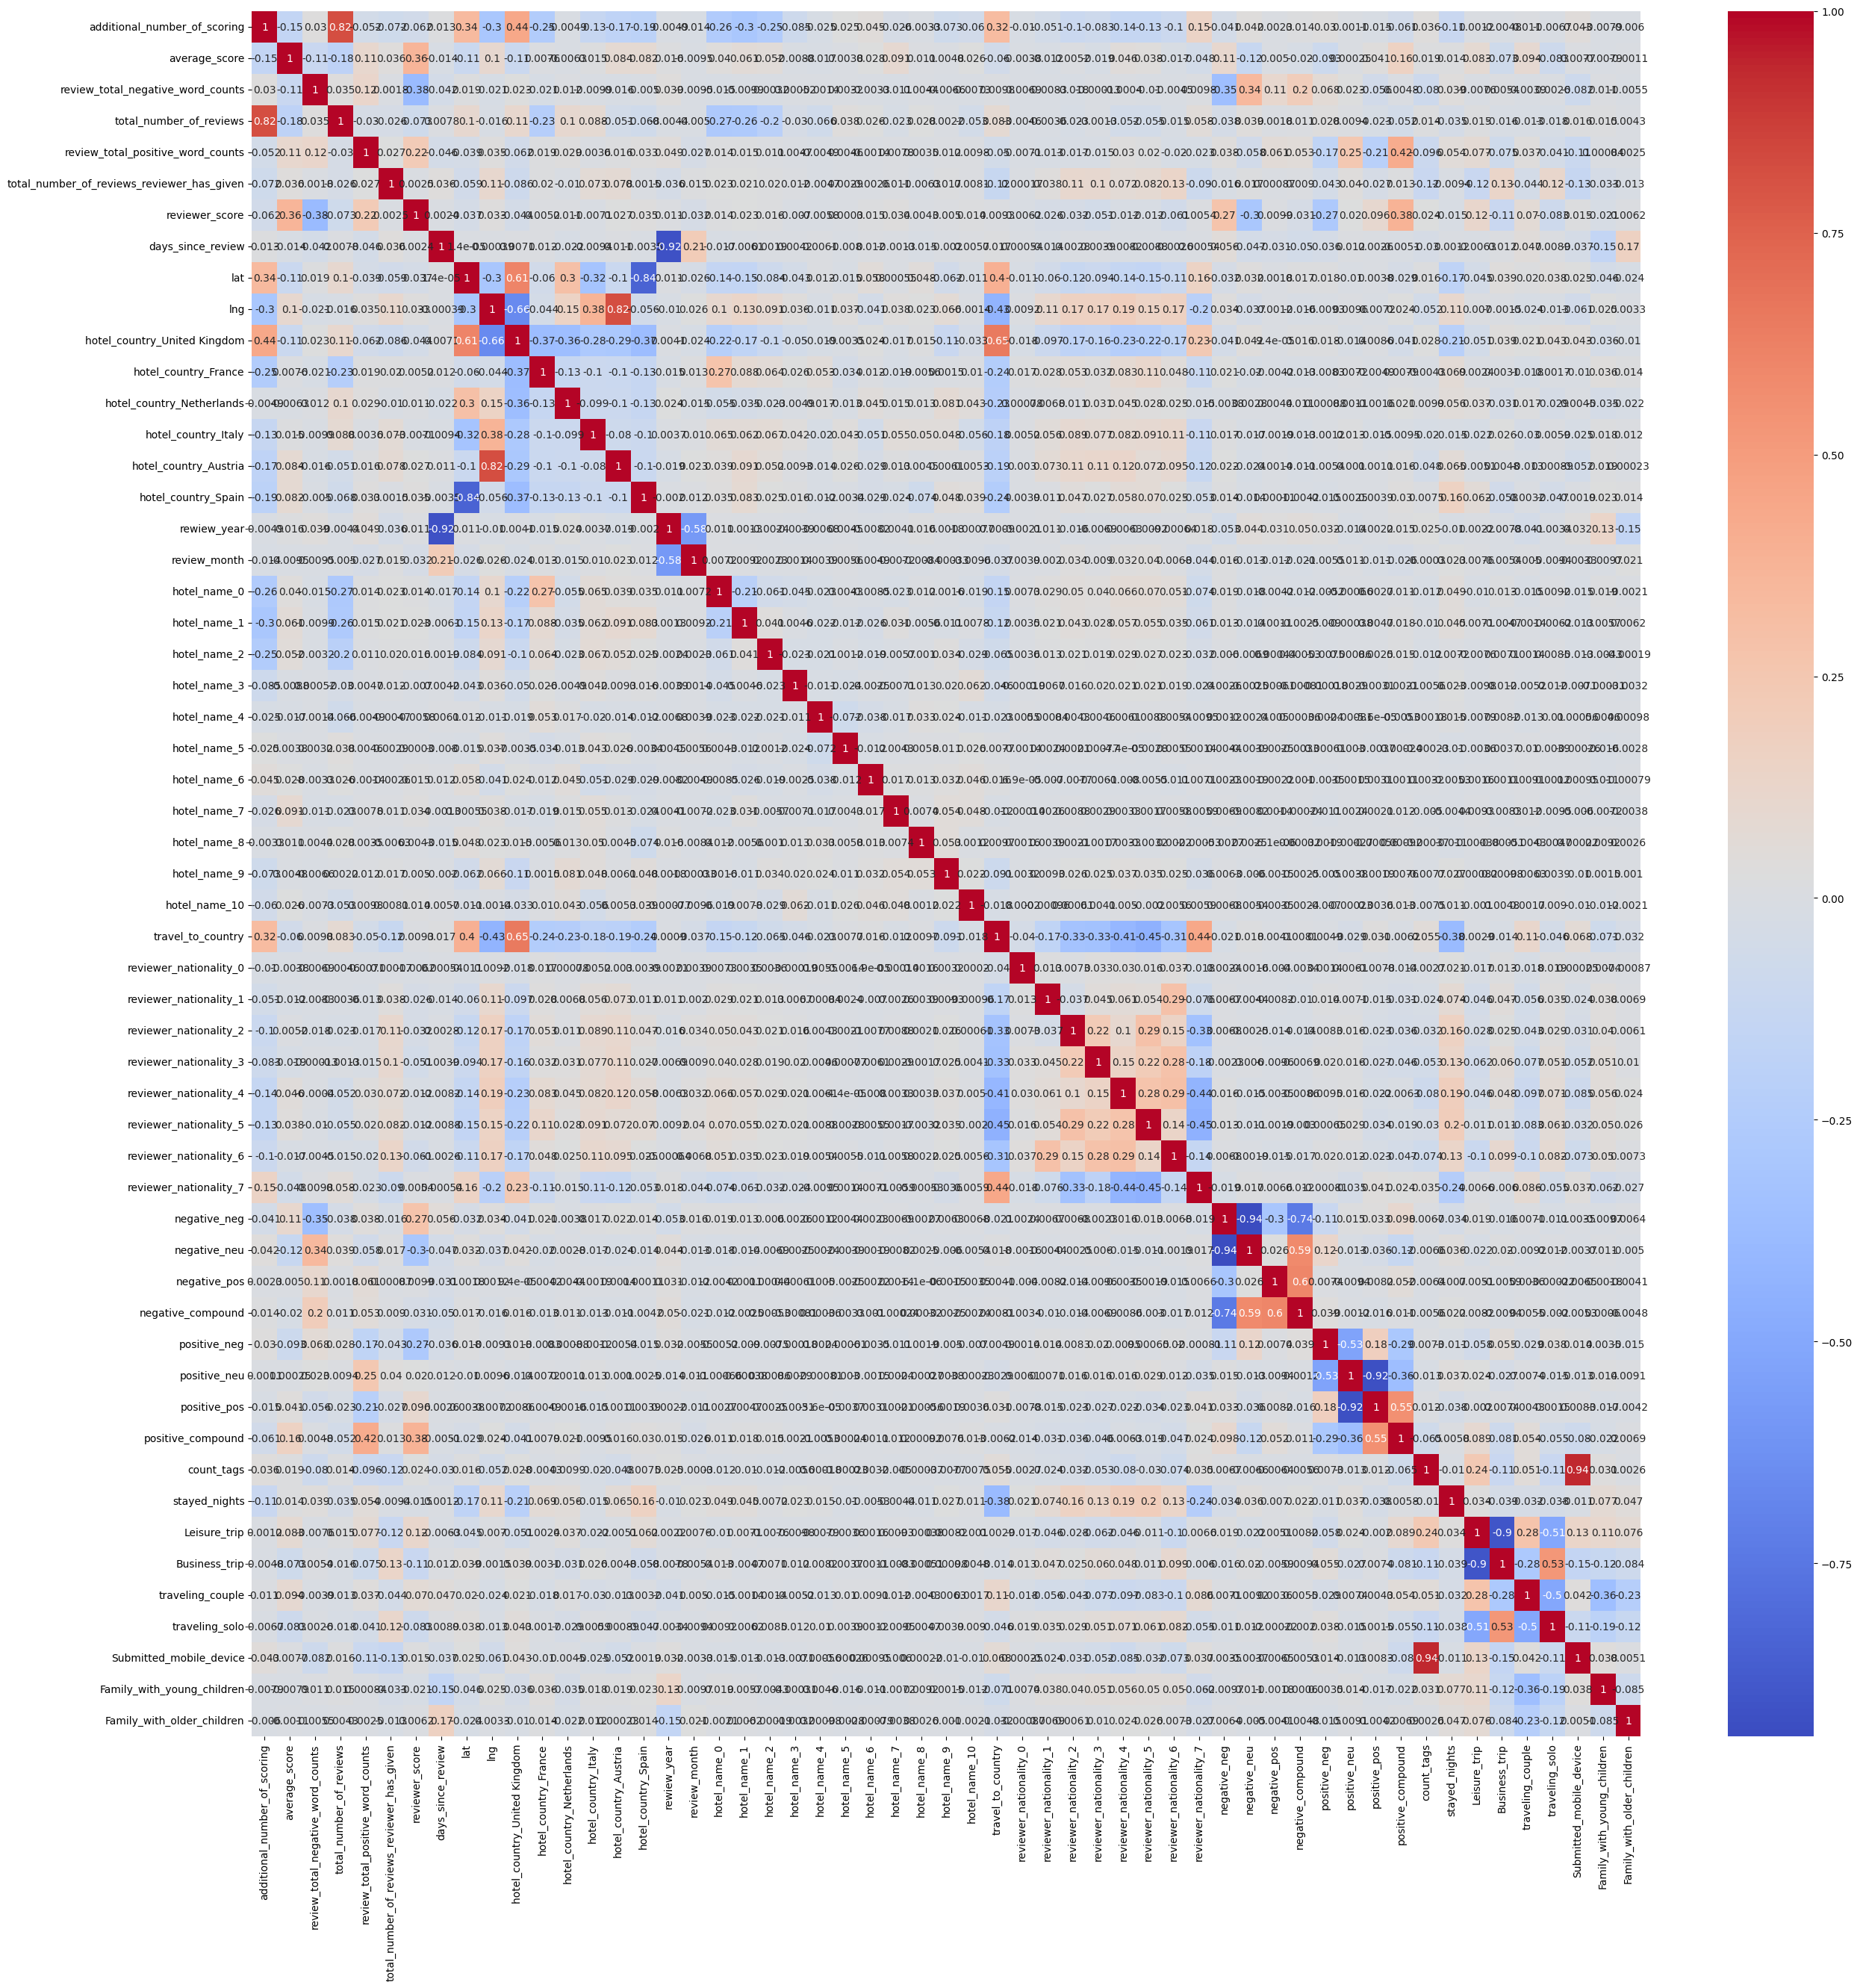

In [44]:
# Смотрим взаимосвязи между признаками. Чтобы не было мультиколлинеарность.

plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(hotels_data.corr(), annot=True, cmap='coolwarm')

Мы можем наблюдать высокую корреляцию между признаками "additional_number_of_scoring" и "total_number_of_reviews" также между поездками 'days_since_review' и 'rewiew_year'

Призднаки 'count_tags' и 'Submitted from a mobile device' и признаки 'Leisure_trip' и 'Business_trip' так же имеют высокую корреляцию между собой.

<AxesSubplot: >

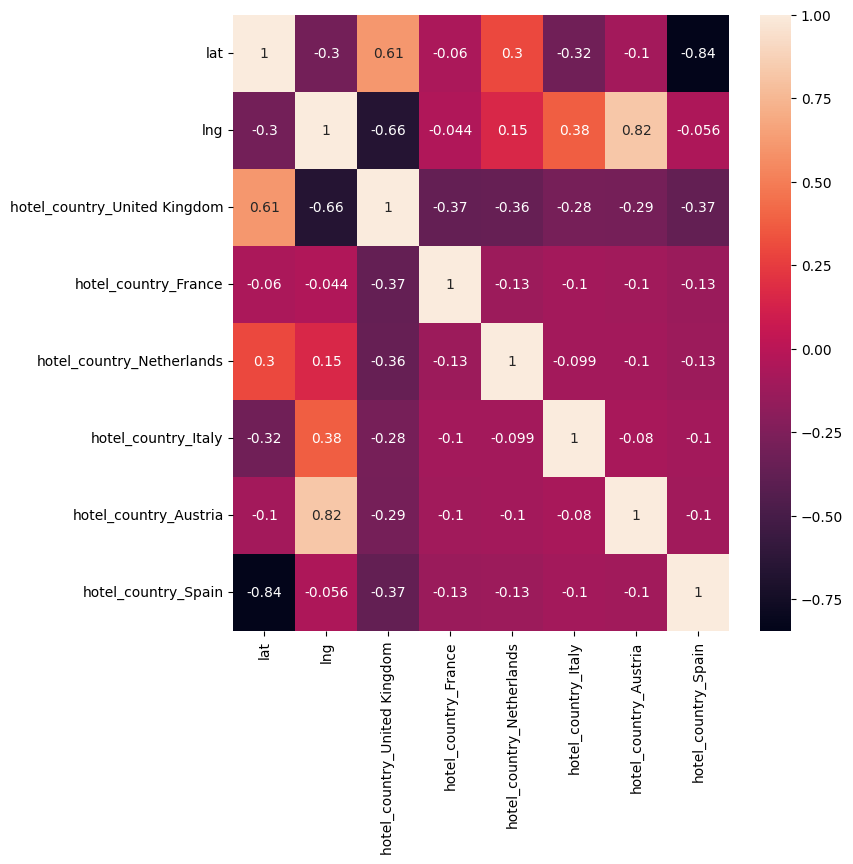

In [45]:
# Подробно посмотрим корреляцию страны отеля и широты с долготой

plt.rcParams['figure.figsize'] = (8,8)
sns.heatmap(hotels_data[['lat','lng','hotel_country_United Kingdom',
       'hotel_country_France',
       'hotel_country_Netherlands',
       'hotel_country_Italy',
       'hotel_country_Austria',
       'hotel_country_Spain']].corr(), annot = True)


<AxesSubplot: >

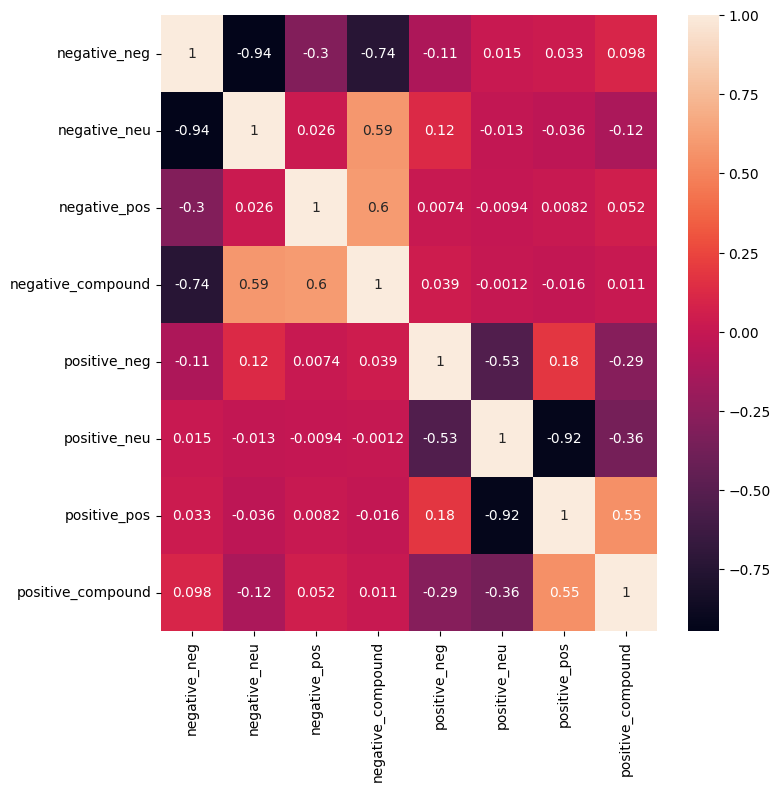

In [46]:
# Так же рассмотрим признаки эмоциональной окраски текста.

plt.rcParams['figure.figsize'] = (8,8)
sns.heatmap(hotels_data[['negative_neg',
                    'negative_neu',
                    'negative_pos',
                    'negative_compound', 
                    'positive_neg', 
                    'positive_neu', 
                    'positive_pos', 
                    'positive_compound']].corr(), annot = True)

<AxesSubplot: >

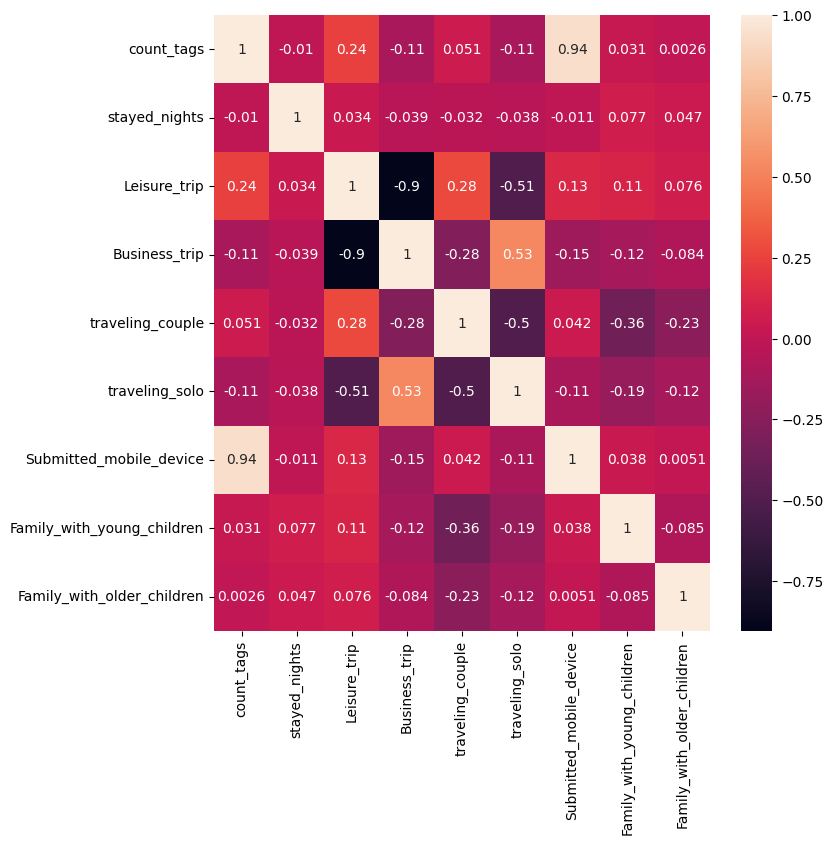

In [47]:
plt.rcParams['figure.figsize'] = (8,8)
sns.heatmap(hotels_data[['count_tags', 'stayed_nights',
                         'Leisure_trip',
                         'Business_trip',
                         'traveling_couple',
                         'traveling_solo',
                         'Submitted_mobile_device',
                         'Family_with_young_children',
                         'Family_with_older_children']].corr(), annot = True)

In [48]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'additional_number_of_scoring','rewiew_year',
            'review_month',
            'review_total_negative_word_counts',
            'total_number_of_reviews_reviewer_has_given', 'days_since_review' ]



# категориальные признаки
cat_cols = [#'average_score',
       'hotel_country_United Kingdom',
       'hotel_country_France',
       'hotel_country_Netherlands',
       'hotel_country_Italy',
       'hotel_country_Austria',
       'hotel_country_Spain', 'hotel_name_0', 
       'hotel_name_1', 'hotel_name_2', 'hotel_name_3',
       'hotel_name_4', 'hotel_name_5', 'hotel_name_6',
       'hotel_name_7', 'hotel_name_8', 'hotel_name_9',
       'hotel_name_10', 'reviewer_nationality_0',
       'reviewer_nationality_1', 'reviewer_nationality_2', 
       'reviewer_nationality_3', 'reviewer_nationality_4',
       'reviewer_nationality_5', 'reviewer_nationality_6',
       'reviewer_nationality_7']

In [49]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_data.drop(['reviewer_score'], axis = 1)  
y = hotels_data['reviewer_score'] 

<AxesSubplot: >

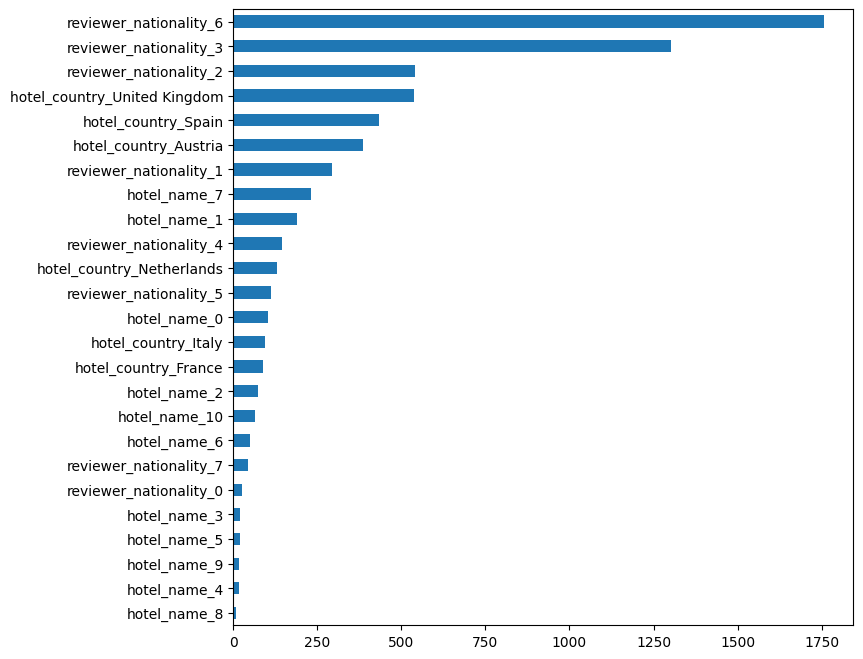

In [50]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot: >

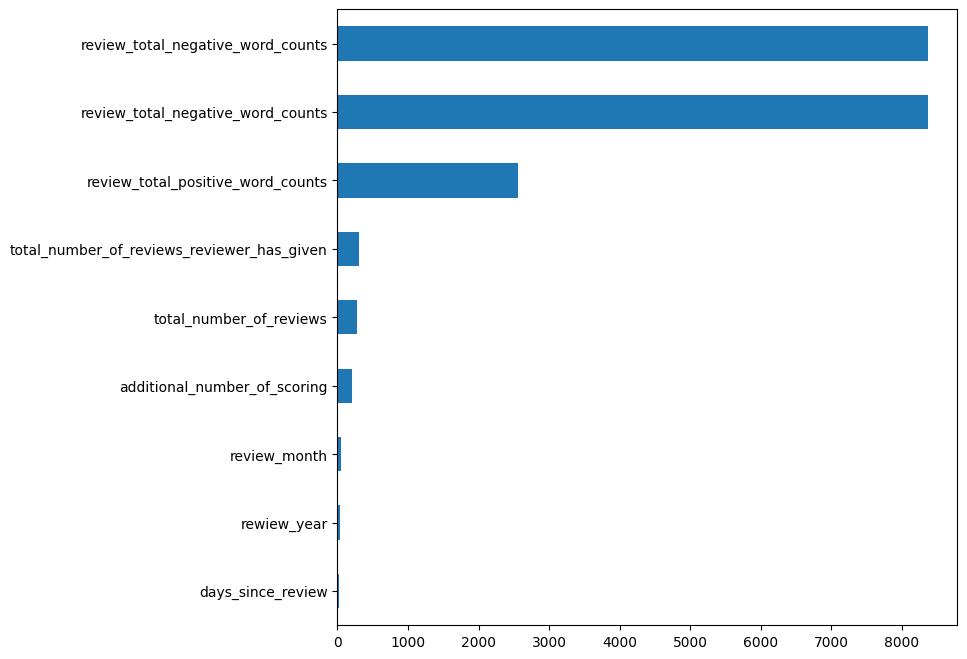

In [51]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [52]:
hotels_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 55 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  float64
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  float64
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  float64
 6   reviewer_score                              386803 non-null  float64
 7   days_since_review                           386803 non-null  int32  
 8   lat                                         386803 non-null  float64
 9   lng                                         386803 non-null  float64
 

In [53]:
hotels_data = hotels_data.drop(['Submitted_mobile_device', 'additional_number_of_scoring', 
                            # 'hotel_country_United Kingdom',
                            # 'hotel_country_France',
                            # 'hotel_country_Netherlands',
                            # 'hotel_country_Italy',
                            # 'hotel_country_Austria',
                            # 'hotel_country_Spain', 
                            # 'rewiew_year',
                            # 'negative_neu',
                            # 'positive_neu',
                            'hotel_name_0', 
                            'hotel_name_1', 'hotel_name_2', 'hotel_name_3',
                            'hotel_name_4', 'hotel_name_5', 'hotel_name_6',
                            'hotel_name_7', 'hotel_name_8', 'hotel_name_9',
                            'hotel_name_10', 'Business_trip',
                            'lat','lng',
                            'reviewer_nationality_0',
                            'reviewer_nationality_1', 'reviewer_nationality_2', 
                            'reviewer_nationality_3', 'reviewer_nationality_4',
                            'reviewer_nationality_5', 'reviewer_nationality_6',
                            'reviewer_nationality_7',
                            'days_since_review'],axis=1) 
hotels_data = hotels_data.drop(['Family_with_young_children', 'Family_with_older_children', ],axis=1) #12.5292  # 12.5494 # 12.54073 # 12.5251

<AxesSubplot: >

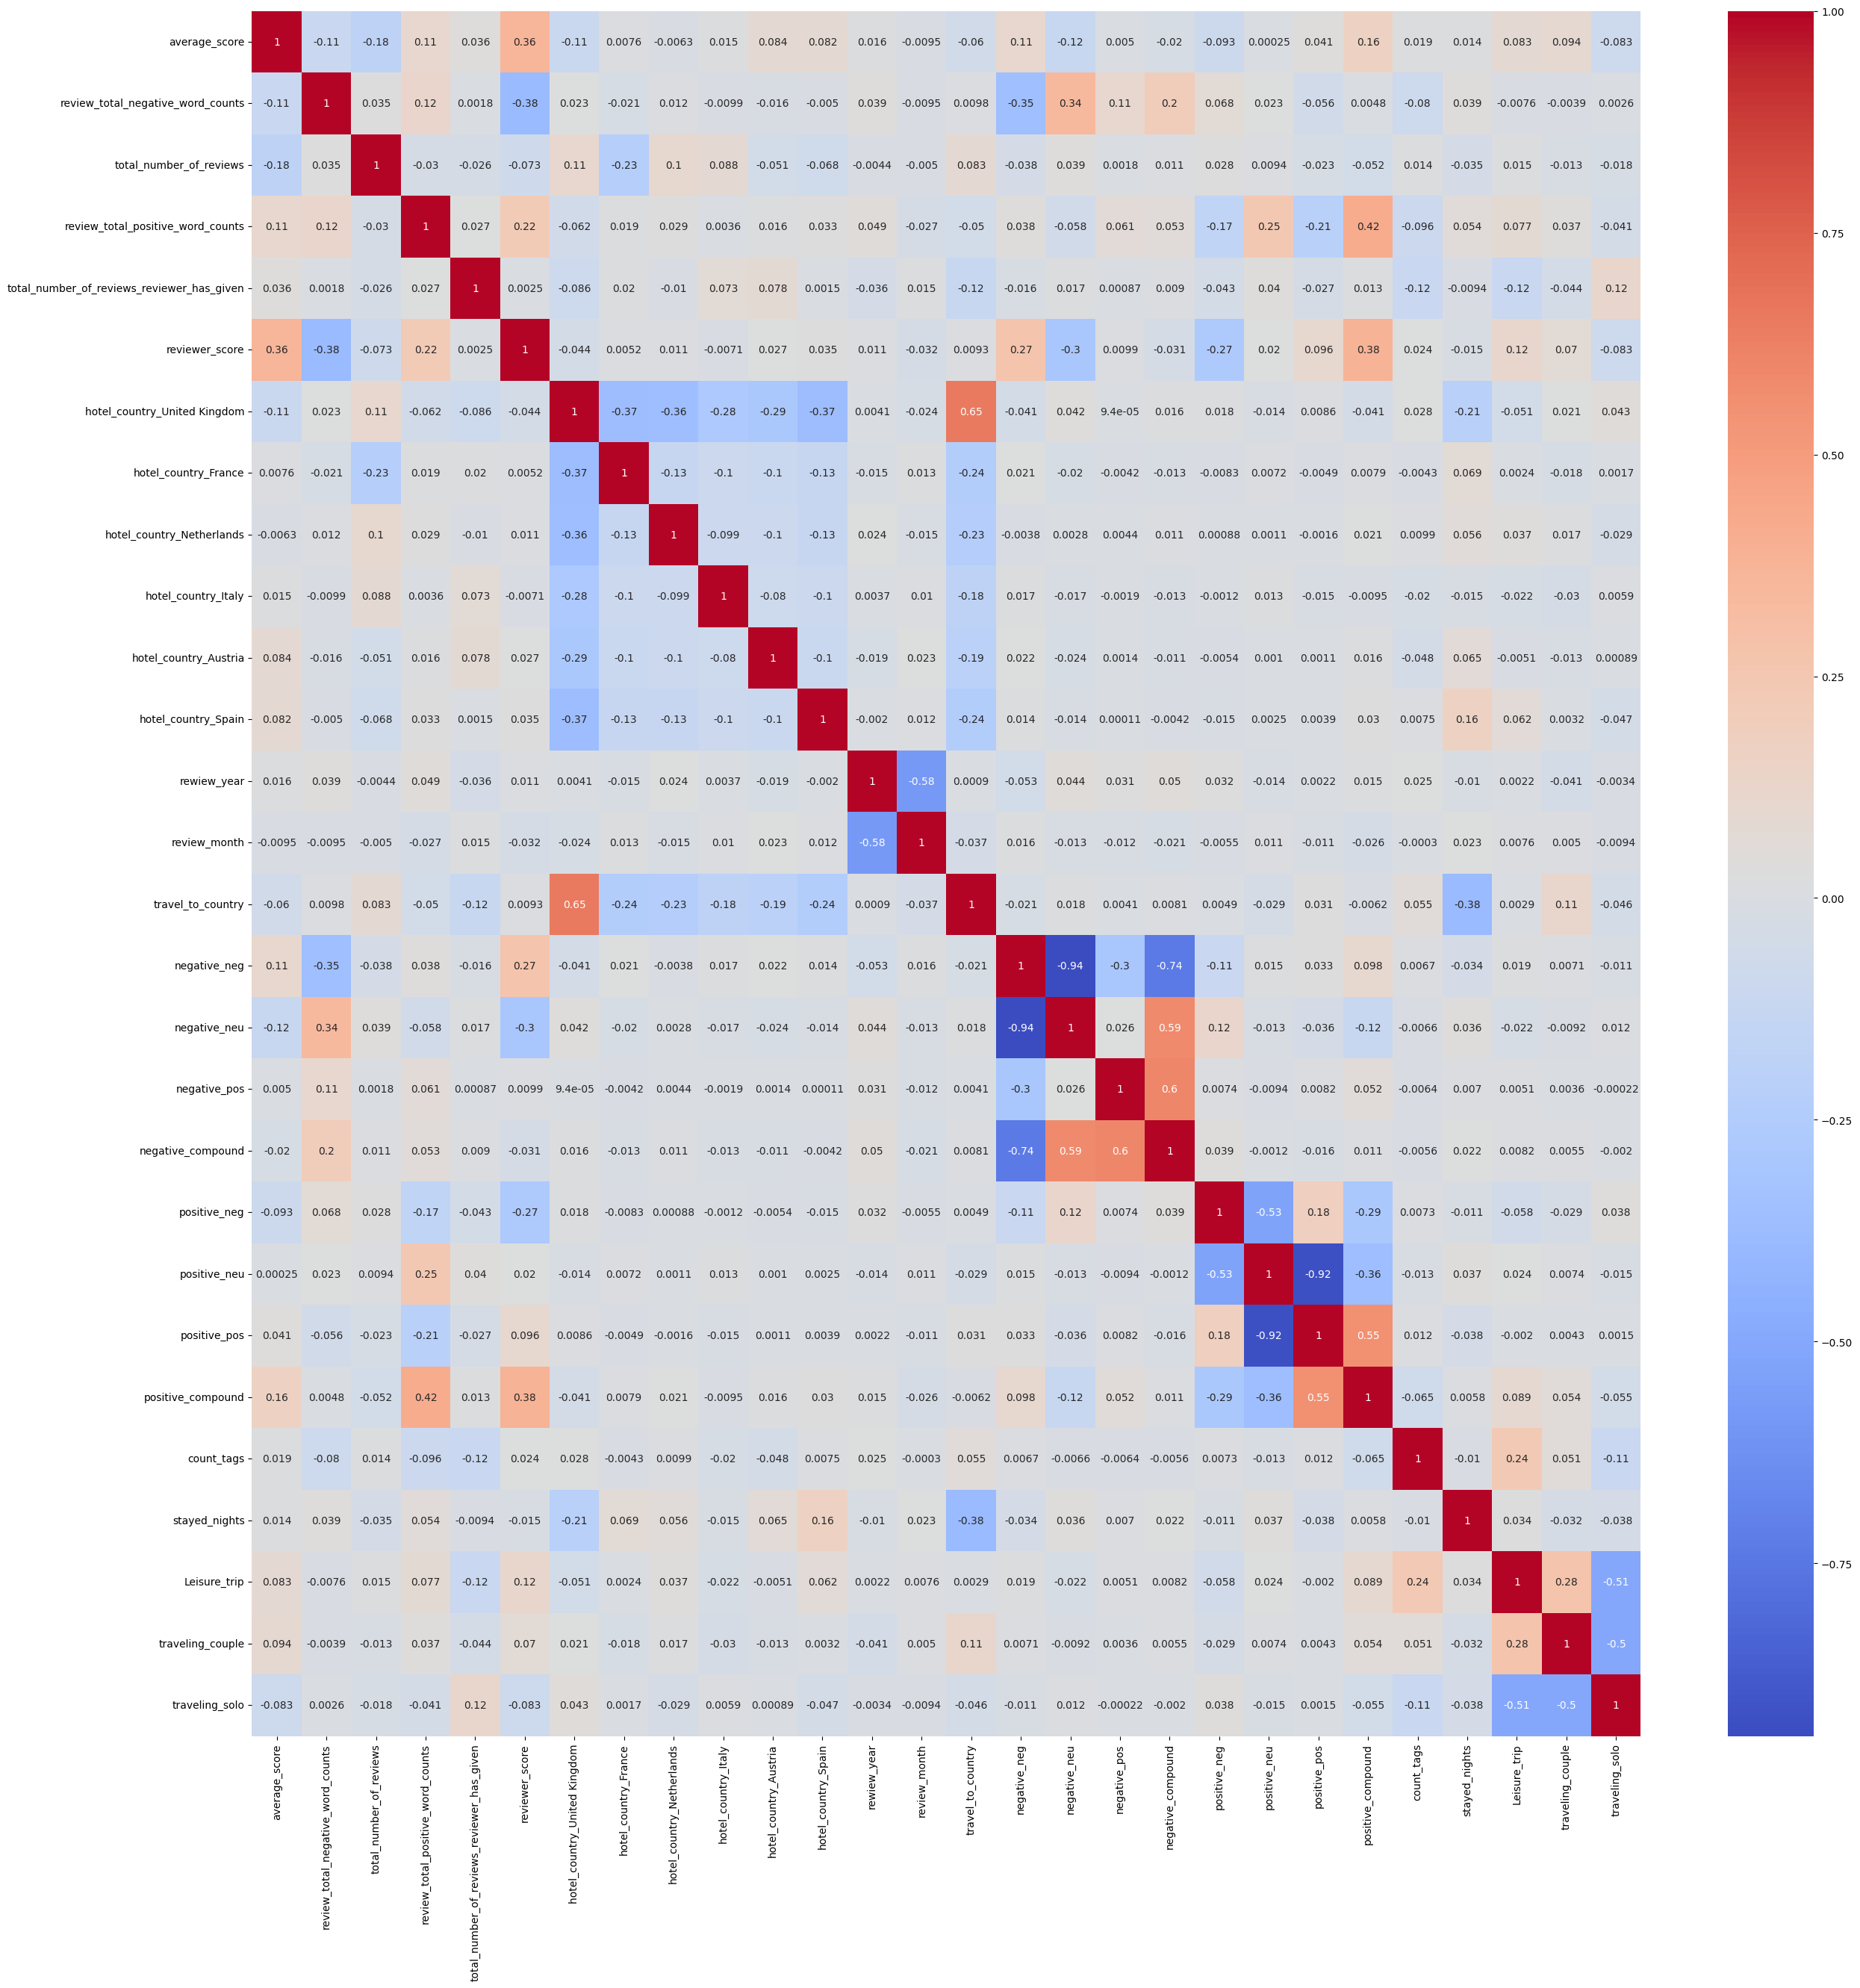

In [54]:
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(hotels_data.corr(), annot=True, cmap='coolwarm')

In [55]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = hotels_data.drop(['reviewer_score'], axis = 1)  
y = hotels_data['reviewer_score']   
# Загружаем специальный инструмент для разбивки:
  
from sklearn.model_selection import train_test_split  
      
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.   
# Для тестирования мы будем использовать 25 % от исходного датасета.
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [56]:
X_test.head()

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,hotel_country_United Kingdom,hotel_country_France,hotel_country_Netherlands,hotel_country_Italy,hotel_country_Austria,...,negative_compound,positive_neg,positive_neu,positive_pos,positive_compound,count_tags,stayed_nights,Leisure_trip,traveling_couple,traveling_solo
177225,0.428571,80,-0.241028,0,-0.285714,1,0,0,0,0,...,-0.7677,0.379,0.000,0.621,0.3400,4,2,0,0,0
259724,-0.285714,41,0.523246,21,1.000000,0,0,1,0,0,...,-0.7793,0.000,0.504,0.496,0.9295,4,2,1,1,0
82496,1.142857,7,-0.611338,7,0.285714,1,0,0,0,0,...,0.0000,0.000,0.227,0.773,0.8807,5,3,1,1,0
318209,-1.428571,48,0.707586,7,5.142857,0,0,1,0,0,...,0.7500,0.000,1.000,0.000,0.0000,5,1,1,0,0
44843,-0.571429,0,0.228385,64,1.428571,0,0,0,0,0,...,-0.7096,0.000,0.597,0.403,0.9886,4,4,1,0,0


In [57]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [58]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290102 entries, 22852 to 121958
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               290102 non-null  float64
 1   review_total_negative_word_counts           290102 non-null  int64  
 2   total_number_of_reviews                     290102 non-null  float64
 3   review_total_positive_word_counts           290102 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  290102 non-null  float64
 5   hotel_country_United Kingdom                290102 non-null  int64  
 6   hotel_country_France                        290102 non-null  int64  
 7   hotel_country_Netherlands                   290102 non-null  int64  
 8   hotel_country_Italy                         290102 non-null  int64  
 9   hotel_country_Austria                       290102 non-null  int64

In [59]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


In [60]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднее отклонение предсказанных значений от фактических.
#Оценка метрики
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))*100

print('MAPE:', MAPE(y_test, y_pred))

MAPE: 12.531691090833915


<AxesSubplot: >

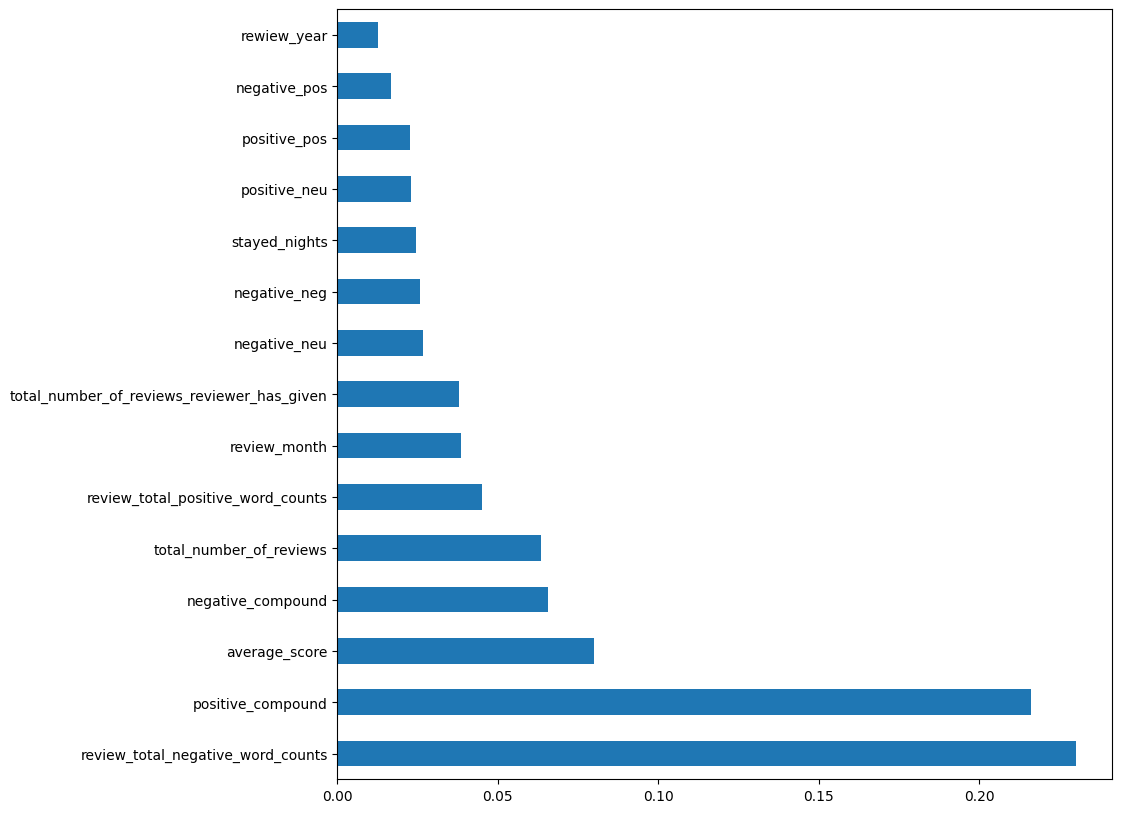

In [61]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')